In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

### Load data 

In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
GS_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs'

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=18.1s


In [4]:
# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: n_cell=3282, n_gene=22966
# TMS facs Marrow: n_cell=14517, n_gene=22966
# TMS facs Pancreas: n_cell=3384, n_gene=22966
# TMS facs SCAT: n_cell=3755, n_gene=22966
# TMS facs Skin: n_cell=4860, n_gene=22966
# TMS facs Spleen: n_cell=3834, n_gene=22966
# TMS facs Thymus: n_cell=4047, n_gene=22966
# TMS facs Tongue: n_cell=3

### Load score 

In [5]:
SCORE_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file'
DIC_SCORE_PATH={'1en2':join(SCORE_PATH,'score.facs.gwas_max_abs_z.top500')}
VERSION_LIST=list(DIC_SCORE_PATH.keys())

dic_trait_list = {x:[] for x in DIC_SCORE_PATH.keys()}
dic_score = {}

for version in DIC_SCORE_PATH.keys():

    SCORE_PATH=DIC_SCORE_PATH[version]
    df_score = None
    for file in [x for x in os.listdir(SCORE_PATH) if '.score.gz' in x]:
        trait = file.replace('.score.gz','')
        dic_trait_list[version].append(trait)
        temp_df = pd.read_csv(join(SCORE_PATH,file), sep='\t', index_col=0)
        temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
        temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]

        if df_score is None:
            df_score = temp_df.copy()
        else:
            df_score = pd.concat([df_score, temp_df], axis=1)
    dic_score[version] = df_score.copy()        

In [6]:
df_score = dic_score['1en2'].copy()
trait_list = sorted(list(set(dic_trait_list['1en2']))).copy()

### Overall per-tissue association 

In [7]:
from sklearn.cluster import SpectralCoclustering

In [8]:
# Per-tissue heatmap 
df_stats = data_facs_ct.obs.copy()
df_stats = df_stats.join((df_score[[x for x in df_score.columns if x.split('.')[-1]=='fdr']]<0.2)*1)
tissue_list = sorted(list(set(df_stats['tissue'])))
key_list = ['tissue_celltype', 'cell_ontology_class']

dic_cell_by_trait = {}
for key in key_list:
    temp_df = data_facs_ct.obs.groupby(key).agg({'cell':len})
    temp_key_list = temp_df.index[temp_df['cell']>100]
    
    temp_df = df_stats.groupby(key).agg({'%s.fdr'%x:np.mean for x in trait_list})
    temp_df = temp_df.loc[temp_key_list]
    temp_df.columns = [x.replace('.fdr','') for x in temp_df.columns]
    dic_cell_by_trait[key] = temp_df.T.copy()

### cell_ontology_class level

In [50]:
dic_cell_by_trait['cell_ontology_class']

cell_ontology_class,B cell,Brush cell of epithelium proper of large intestine,"CD4-positive, alpha-beta T cell","CD8-positive, alpha-beta T cell",DN4 thymocyte,Kupffer cell,NK cell,T cell,adventitial cell,aortic endothelial cell,...,skeletal muscle satellite cell,smooth muscle cell,smooth muscle cell of the pulmonary artery,smooth muscle cell of trachea,stromal cell,thymocyte,type II pneumocyte,valve cell,vein endothelial cell,ventricular myocyte
PASS_ADHD_Demontis2018,0.001066,0.000000,0.000855,0.000935,0.000569,0.0,0.000000,0.003010,0.00000,0.002141,...,0.000367,0.000000,0.0,0.000,0.000000,0.001231,0.0,0.0,0.0,0.0
PASS_AdultOnsetAsthma_Ferreira2019,0.002665,0.000000,0.129060,0.072897,0.111048,0.0,0.033067,0.138450,0.00692,0.000000,...,0.001101,0.009709,0.0,0.000,0.000000,0.042462,0.0,0.0,0.0,0.0
PASS_AgeFirstBirth,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.004037,0.000000,0.0,0.016,0.000000,0.003692,0.0,0.0,0.0,0.0
PASS_AgeOfInitiation_Liu2019,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0
PASS_Alzheimer,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKB_460K.repro_MENOPAUSE_AGE,0.000711,0.000000,0.000000,0.000000,0.000569,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0,0.000,0.000000,0.001231,0.0,0.0,0.0,0.0
UKB_460K.repro_NumberChildrenEverBorn_Female,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.002141,...,0.000367,0.000000,0.0,0.000,0.000000,0.001846,0.0,0.0,0.0,0.0
UKB_460K.repro_NumberChildrenEverBorn_Male,0.000711,0.005714,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00346,0.000000,...,0.001835,0.000000,0.0,0.040,0.003175,0.006154,0.0,0.0,0.0,0.0
UKB_460K.repro_NumberChildrenEverBorn_Pooled,0.000178,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00346,0.000000,...,0.001468,0.000000,0.0,0.008,0.000000,0.003077,0.0,0.0,0.0,0.0


# n_cluster=2   prop_val=0.9726  prop_elements=0.4659
# n_cluster=3   prop_val=0.9633  prop_elements=0.4253
# n_cluster=4   prop_val=0.9535  prop_elements=0.3481
# n_cluster=5   prop_val=0.9572  prop_elements=0.3629
# n_cluster=6   prop_val=0.9519  prop_elements=0.3424
# n_cluster=7   prop_val=0.9223  prop_elements=0.1921
# n_cluster=8   prop_val=0.9079  prop_elements=0.1716
# n_cluster=9   prop_val=0.9150  prop_elements=0.1675
# n_cluster=10  prop_val=0.8833  prop_elements=0.1319
# n_cluster=11  prop_val=0.8857  prop_elements=0.1598
# n_cluster=12  prop_val=0.8769  prop_elements=0.1308
# n_cluster=13  prop_val=0.8698  prop_elements=0.1257
# n_cluster=14  prop_val=0.8510  prop_elements=0.1220


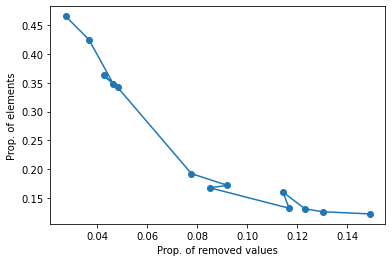

In [9]:
key='cell_ontology_class'
df_plot = dic_cell_by_trait[key].copy()
df_plot = df_plot.loc[(df_plot>0.1).sum(axis=1)>0]
df_plot = df_plot.loc[:, (df_plot>0.1).sum(axis=0)>0]

# bi-clustering by spectral co-clustering
n_cluster_list = list(range(2, 15))
v_prop_val = np.zeros(len(n_cluster_list))
v_prop_element = np.zeros(len(n_cluster_list))
for i_config,n_cluster in enumerate(n_cluster_list):
    
    model = SpectralCoclustering(n_clusters=n_cluster, random_state=0)
    model.fit(df_plot.values)
    
    # Compute clustering quality 
    v_prop_val[i_config] = 0 
    v_prop_element[i_config] = 0
    for i_cluster in range(n_cluster):
        temp_mat = model.get_submatrix(i_cluster, df_plot.values)
        v_prop_val[i_config] += temp_mat.sum()
        v_prop_element[i_config] += temp_mat.size
    v_prop_val[i_config] /= df_plot.values.sum()
    v_prop_element[i_config] /= df_plot.size
    print('# n_cluster=%-3d prop_val=%0.4f  prop_elements=%0.4f'
          %(n_cluster, v_prop_val[i_config], v_prop_element[i_config]))
    
plt.figure()
plt.plot(1-v_prop_val, v_prop_element, 'o-')
plt.xlabel('Prop. of removed values')
plt.ylabel('Prop. of elements')
plt.show()

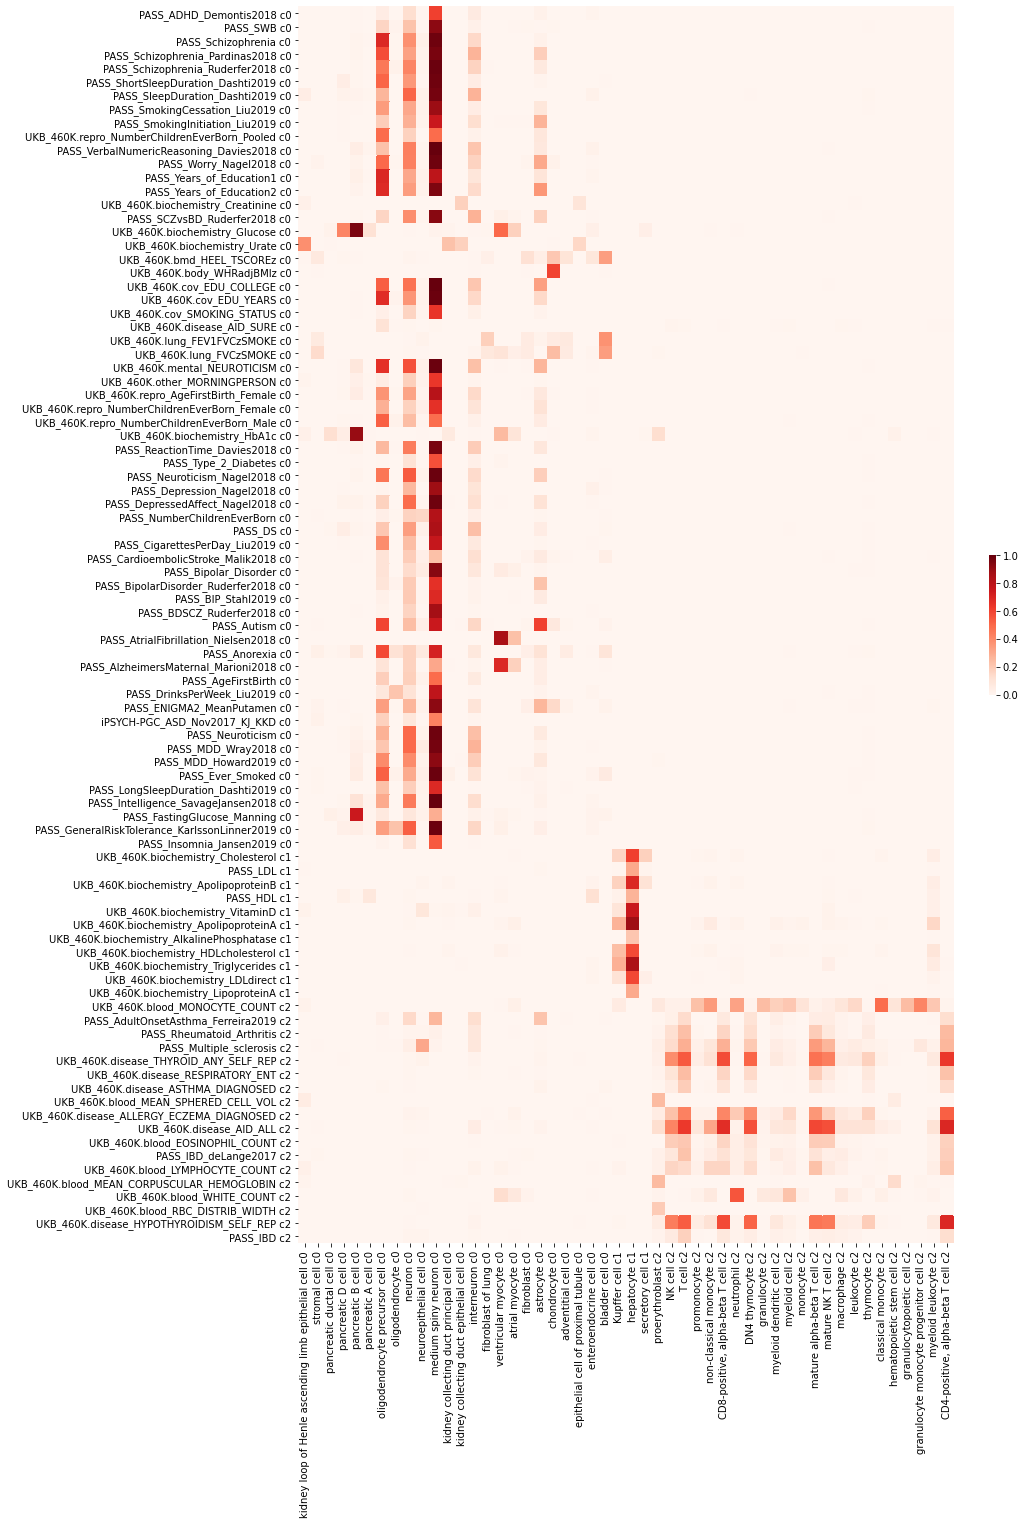

In [20]:
n_cluster = 3
model = SpectralCoclustering(n_clusters=n_cluster, random_state=0)
model.fit(df_plot.values)

df_plot_reorder = df_plot.copy()
df_plot_reorder.index = ['%s c%d'%(x,y) for x,y in zip(df_plot.index, model.row_labels_)]
df_plot_reorder.columns = ['%s c%d'%(x,y) for x,y in zip(df_plot.columns, model.column_labels_)]
df_plot_reorder = df_plot_reorder.iloc[np.argsort(model.row_labels_), np.argsort(model.column_labels_)]

plt.figure(figsize=[0.25*df_plot_reorder.shape[1], 0.25*df_plot_reorder.shape[0]])
sns.heatmap(df_plot_reorder, vmin=0, vmax=1, cmap='Reds', cbar=True, cbar_kws={'fraction':0.01})
plt.show()

62
11
18


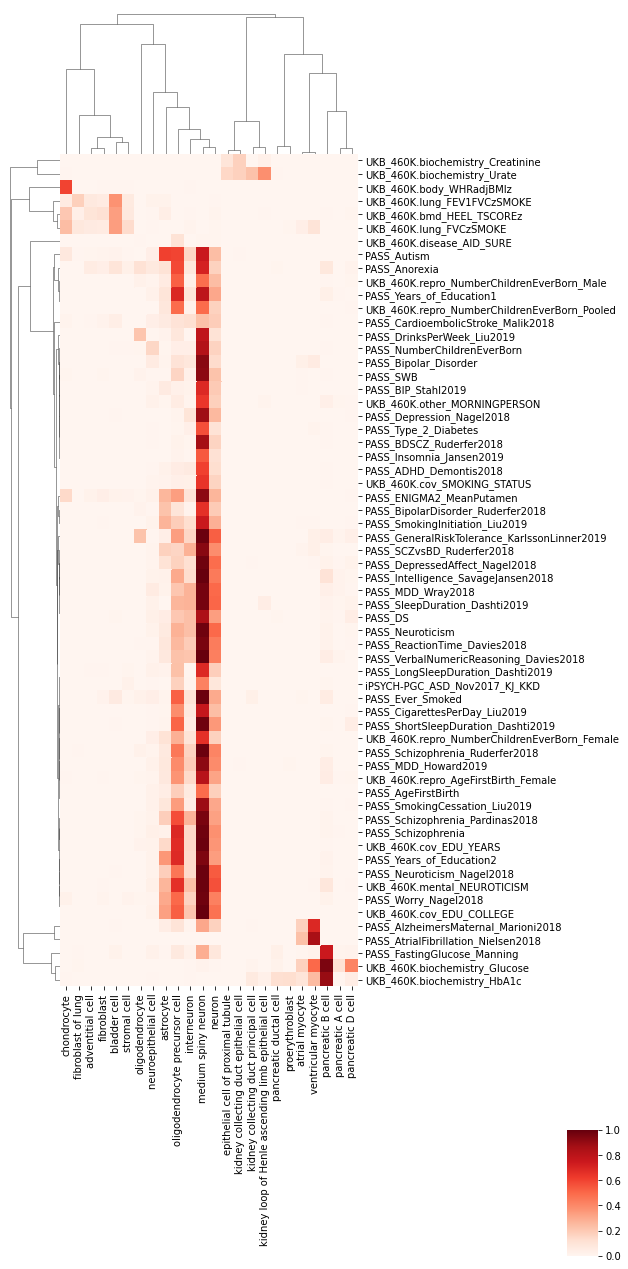

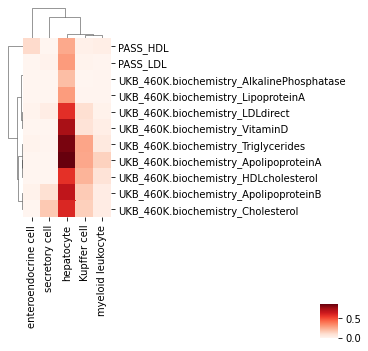

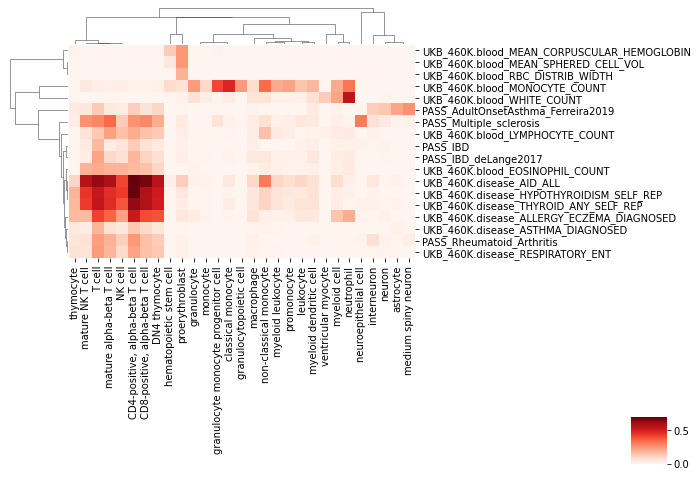

In [49]:
for i_cluster in range(n_cluster):
    rows,cols = model.get_indices(i_cluster)
    print(rows.shape[0])
    if (rows.shape[0]==0):
        continue
        
    df_plot_sub = df_plot.iloc[rows,:].copy()
    df_plot_sub = df_plot_sub.loc[:, (df_plot_sub>0.1).sum(axis=0)>0]
    df_plot_sub.columns.name = None
    
    clustermapParams = { 'square': False }
    sns.clustermap(df_plot_sub, metric='cosine', 
                   figsize=(4+0.2*df_plot_sub.shape[1], 2+0.25*df_plot_sub.shape[0]), 
                   cmap='Reds', dendrogram_ratio=0.15,
                   cbar_pos=(0.9, 0, 0.05, 0.1))
#     break

In [ ]:
for i_cluster in range(n_cluster):
    rows,cols = model.get_indices(i_cluster)
    print(rows.shape[0])
    if (rows.shape[0]==0):
        continue
        
    df_plot_sub = df_plot.iloc[rows,:].copy()
    df_plot_sub = df_plot_sub.loc[:, (df_plot_sub>0.1).sum(axis=0)>0]